In [ ]:
!pip install xmltodict
!pip install split-folders
!pip install GPUtil

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7409 sha256=eaa33fb4d454fbed202065698ea090148d72ed0de03035a4fcddd52a0e8ea12f
  Stored in directory: /root/.cache/pip/wheels/ba/03/bb/7a97840eb54479b328672e15a536e49dc60da200fb21564d53
Successfully built GPUtil


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# New Section

In [ ]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import numpy as np
import cv2
import uuid
import time
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import xmltodict
import glob
import xml.etree.ElementTree as ET
import random as rnd
import splitfolders

from pathlib import Path
from sklearn.model_selection import train_test_split
from collections import Counter
from PIL import Image
from tqdm.auto import tqdm
from GPUtil import showUtilization as gpu_usage
from numba import cuda
from timeit import default_timer as timer

import torch

import matplotlib
# matplotlib.use('TkAgg')

from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from matplotlib import patches as mpatches

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!ls "/content/drive/My Drive/Machine Learning/archive"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
annotations  images  labels  masks.yaml  yolov5


In [ ]:
img_names=[] 
annotations=[]
# archive: uploaded to google drive
for dirname, _, filenames in os.walk("/content/drive/My Drive/Machine Learning/archive"):
    for filename in filenames:
        if os.path.join(dirname, filename)[-3:]==("png" or "jpg"):
            img_names.append(filename)
        elif os.path.join(dirname, filename)[-3:]=="xml":
            annotations.append(filename)

In [ ]:
img_names[:10]

['maksssksksss0.png',
 'maksssksksss1.png',
 'maksssksksss106.png',
 'maksssksksss112.png',
 'maksssksksss104.png',
 'maksssksksss100.png',
 'maksssksksss139.png',
 'maksssksksss108.png',
 'maksssksksss120.png',
 'maksssksksss135.png']

In [ ]:
annotations[:10]

['maksssksksss110.xml',
 'maksssksksss103.xml',
 'maksssksksss11.xml',
 'maksssksksss109.xml',
 'maksssksksss101.xml',
 'maksssksksss10.xml',
 'maksssksksss104.xml',
 'maksssksksss108.xml',
 'maksssksksss107.xml',
 'maksssksksss0.xml']

In [ ]:
dataset = {
            "file":[],
            "classnames":[],
            "class_id":[],
            "width":[],
            "height":[],
            "xmin":[],
            "ymin":[],
            "xmax":[],
            "ymax":[]
           }

In [ ]:
path_annotations="/content/drive/My Drive/Machine Learning/archive/annotations/*.xml" 

for item in glob.glob(path_annotations):
  tree = ET.parse(item)
    
  for elem in tree.iter():
    finlname=''
    if 'filename' in elem.tag:
      filename=elem.text
    elif 'width' in elem.tag:
      width=int(elem.text)
    elif 'height' in elem.tag:
      height=int(elem.text)
    elif 'name' in elem.tag:
      classname=elem.text
    elif 'xmin' in elem.tag:
      xmin=int(elem.text)
    elif 'ymin' in elem.tag:
      ymin=int(elem.text)
    elif 'xmax' in elem.tag:
      xmax=int(elem.text)
    elif 'ymax' in elem.tag:
      ymax=int(elem.text)
            
      dataset['file'].append(filename)
      dataset['classnames'].append(classname)
      dataset['width'].append(width)
      dataset['height'].append(height)
      dataset['xmin'].append(xmin)
      dataset['ymin'].append(ymin)
      dataset['xmax'].append(xmax)
      dataset['ymax'].append(ymax)

In [ ]:
classes = ['without_mask', 'with_mask', 'mask_weared_incorrect']

for i, v in enumerate(dataset['classnames']):
  dataset['class_id'].append(classes.index(dataset['classnames'][i]))
    

In [ ]:
for key in dataset:
  print(key, len(dataset[key]))

file 4072
classnames 4072
class_id 4072
width 4072
height 4072
xmin 4072
ymin 4072
xmax 4072
ymax 4072


In [ ]:
df=pd.DataFrame(dataset)
df.shape

(4072, 9)

In [ ]:
print(f'''Sum of 'without_mask' labels: {sum(df.classnames == 'without_mask')}''')
print(f'''Sum of 'mask_weared_incorrect' labels: {sum(df.classnames == 'mask_weared_incorrect')}''')
print(f'''Sum of 'with_mask' labels: {sum(df.classnames == 'with_mask')}''')

Sum of 'without_mask' labels: 717
Sum of 'mask_weared_incorrect' labels: 123
Sum of 'with_mask' labels: 3232


In [ ]:
df = df[df.classnames != 'mask_weared_incorrect']
df.reset_index(drop=True, inplace=True)
classes = ['without_mask', 'with_mask']

In [ ]:
df

,file,classnames,class_id,width,height,xmin,ymin,xmax,ymax
0,maksssksksss110.png,without_mask,0,400,267,6,111,43,148
1,maksssksksss110.png,without_mask,0,400,267,22,20,49,46
2,maksssksksss110.png,with_mask,1,400,267,48,12,70,37
3,maksssksksss110.png,with_mask,1,400,267,113,1,136,24
4,maksssksksss110.png,without_mask,0,400,267,78,17,106,46
...,...,...,...,...,...,...,...,...,...
3944,maksssksksss82.png,with_mask,1,400,225,57,67,79,89
3945,maksssksksss82.png,with_mask,1,400,225,149,45,172,72
3946,maksssksksss82.png,with_mask,1,400,225,192,36,215,65
3947,maksssksksss82.png,with_mask,1,400,225,241,74,262,97


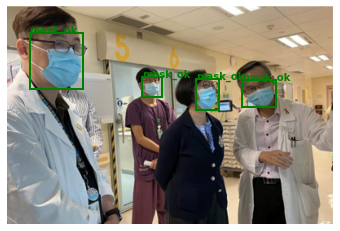

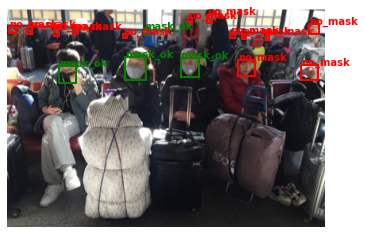

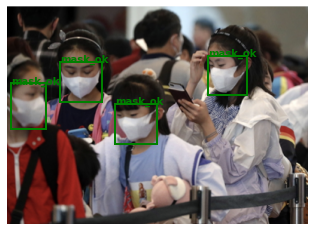

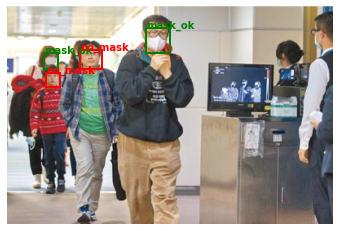

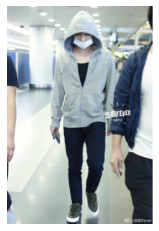

In [ ]:
%matplotlib inline

def print_random_images(photos: list, n: int = 5, seed=None) -> None:
    if n > 10:
        n=10
    
    if seed:
        rnd.seed(seed)
        
    random_photos = rnd.sample(photos, n)
    
    for image_path in random_photos:
        
        with Image.open(image_path) as fd:
            fig, ax = plt.subplots()
            ax.imshow(fd)           
            ax.axis(False)
            
            for i, file in enumerate(df.file):
                if file in image_path:
                    x1,y1,x2,y2=list(df.iloc[i, -4:])
                    
                    if df.class_id[i] == 0:
                        color = 'r'
                        annotation = 'no_mask'
                    elif df.class_id[i] == 1:
                        color = 'g'
                        annotation = 'mask_ok'
                        
                    mpatch=mpatches.Rectangle((x1,y1),x2-x1,y2-y1,linewidth=1, edgecolor=color,facecolor="none",lw=2,)                    
                    ax.add_patch(mpatch)
                    rx, ry = mpatch.get_xy()
                    ax.annotate(annotation, (rx, ry), color=color, weight='bold', fontsize=10, ha='left', va='baseline')
                    
photos_path = "/content/drive/MyDrive/Machine Learning/archive/images/*.png"
photos_list = glob.glob(photos_path)

print_random_images(photos_list)

In [ ]:
x_pos = []
y_pos = []
frame_width = []
frame_height = []

labels_path = Path("/content/drive/MyDrive/Machine Learning/archive/labels")

labels_path.mkdir(parents=True, exist_ok=True)

save_type = 'w'

for i, row in enumerate(df.iloc):
    current_filename = str(row.file[:-4])
    
    width, height, xmin, ymin, xmax, ymax = list(df.iloc[i][-6:])
    
    x=(xmin+xmax)/2/width
    y=(ymin+ymax)/2/height
    width=(xmax-xmin)/width
    height=(ymax-ymin)/height
    
    x_pos.append(x)
    y_pos.append(y)
    frame_width.append(width)
    frame_height.append(height)
    
    txt = str(row.class_id) + ' ' + str(x) + ' ' + str(y) + ' ' + str(width) + ' ' + str(height) + '\n'
    
    if i > 0:
        previous_filename = str(df.file[i-1][:-4])
        save_type='a+' if current_filename == previous_filename else 'w'
    
    
    with open("/content/drive/MyDrive/Machine Learning/archive/labels/" + str(row.file[:-4]) +'.txt', save_type) as f:
        f.write(txt)
        
        
df['x_pos']=x_pos
df['y_pos']=y_pos
df['frame_width']=frame_width
df['frame_height']=frame_height

df

,file,classnames,class_id,width,height,xmin,ymin,xmax,ymax,x_pos,y_pos,frame_width,frame_height
0,maksssksksss110.png,without_mask,0,400,267,6,111,43,148,0.06125,0.485019,0.0925,0.138577
1,maksssksksss110.png,without_mask,0,400,267,22,20,49,46,0.08875,0.123596,0.0675,0.097378
2,maksssksksss110.png,with_mask,1,400,267,48,12,70,37,0.14750,0.091760,0.0550,0.093633
3,maksssksksss110.png,with_mask,1,400,267,113,1,136,24,0.31125,0.046816,0.0575,0.086142
4,maksssksksss110.png,without_mask,0,400,267,78,17,106,46,0.23000,0.117978,0.0700,0.108614
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3944,maksssksksss82.png,with_mask,1,400,225,57,67,79,89,0.17000,0.346667,0.0550,0.097778
3945,maksssksksss82.png,with_mask,1,400,225,149,45,172,72,0.40125,0.260000,0.0575,0.120000
3946,maksssksksss82.png,with_mask,1,400,225,192,36,215,65,0.50875,0.224444,0.0575,0.128889
3947,maksssksksss82.png,with_mask,1,400,225,241,74,262,97,0.62875,0.380000,0.0525,0.102222


In [ ]:
input_folder = Path("/content/drive/MyDrive/Machine Learning/archive")
output_folder = Path("/content/drive/MyDrive/Machine Learning/imagelabel")
splitfolders.ratio(
    input_folder,
    output=output_folder,
    seed=42,
    ratio=(0.8, 0.2),
    group_prefix=None
)
print("Moving files finished.")

In [ ]:
def walk_through_dir(dir_path: Path) -> None:
    """Prints dir_path content"""
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directiories and {len(filenames)} files in '{dirpath}' folder ")

    
walk_through_dir(input_folder)
print()
walk_through_dir(output_folder)

In [ ]:
import yaml

yaml_file = '/content/drive/MyDrive/Machine Learning/imagelabel/masks.yaml'

yaml_data = dict(
    path = "/content/drive/MyDrive/Machine Learning/imagelabel/",
    train = "train",
    val = "val",
    nc = len(classes),
    names = classes
)

with open(yaml_file, 'w') as f:
    yaml.dump(yaml_data, f, explicit_start = True, default_flow_style = False)
    
device = '0' if torch.cuda.is_available() else 'cpu'
device

'0'

In [ ]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 14432, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 14432 (delta 35), reused 42 (delta 25), pack-reused 14371
Receiving objects: 100% (14432/14432), 13.63 MiB | 8.99 MiB/s, done.
Resolving deltas: 100% (9929/9929), done.


In [ ]:
%cd /content/drive/MyDrive/Machine Learning/yolov5
# %pip install -qr requirements.txt

/content/drive/.shortcut-targets-by-id/1nFnGwBFeVHT_QdYNh7CXMpvRiFtliaQY/Machine Learning/yolov5


In [ ]:
!pip install comet_ml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 446 kB 34.2 MB/s 
     |████████████████████████████████| 502 kB 62.7 MB/s 
     |████████████████████████████████| 139 kB 73.0 MB/s 
     |████████████████████████████████| 54 kB 3.7 MB/s 
     |████████████████████████████████| 54 kB 3.6 MB/s 
     |████████████████████████████████| 168 kB 79.9 MB/s 
     |████████████████████████████████| 140 kB 77.0 MB/s 
     |████████████████████████████████| 127 kB 56.3 MB/s 
     |████████████████████████████████| 168 kB 82.2 MB/s 
     |████████████████████████████████| 166 kB 67.7 MB/s 
     |████████████████████████████████| 166 kB 83.3 MB/s 
     |████████████████████████████████| 162 kB 86.2 MB/s 
     |████████████████████████████████| 162 kB 82.4 MB/s 
     |████████████████████████████████| 158 kB 85.4 MB/s 
     |████████████████████████████████| 157 kB 80.0 MB/s 
     |█████████████████████████████

In [ ]:
!export COMET_API_KEY=57S2XgpAp0SuZPM8kdG2kS45t

In [ ]:
start_time = timer()

!export COMET_API_KEY=57S2XgpAp0SuZPM8kdG2kS45t
# !cd yolov5 && python3 train.py --workers 2 --img 640 --batch 16 --epochs 50 --data "data/masks.yaml" --weights yolov5s.pt --device {device} --cache
!python3 train.py --workers 2 --img 640 --epochs 50 --data "/content/drive/MyDrive/Machine Learning/imagelabel/masks.yaml" --weights yolov5s.pt --device {device} --cache

end_time = timer()

print(f'Training time: {(end_time-start_time):.2f}')

requirements: YOLOv5 requirement "gitpython" not found, attempting AutoUpdate...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/

requirements: 1 package updated per ['gitpython']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

train: weights=yolov5s.pt, cfg=, data=/content/drive/MyDrive/Machine Learning/imagelabel/masks.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=0, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=2, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
Command 'git fetch origin' timed out after 5 seconds
r

In [ ]:
model = torch.hub.load('ultralytics/yolov5', 
                       'custom', 
                       path = '/content/drive/MyDrive/Machine Learning/yolov5/runs/train/exp4/weights/best.pt', 
                       force_reload=True)

/usr/local/lib/python3.8/dist-packages/torch/hub.py:267: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
Copying files: 1131 files [10:15,  1.84 files/s]
requirements: YOLOv5 requirements "gitpython" "ipython" not found, attempting AutoUpdate...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/

requireme

Populating the interactive namespace from numpy and matplotlib


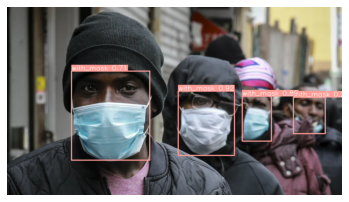

Image from: https://www.freepik.com/free-photo/male-employee-wearing-face-mask-work-standing_11651930.htm#query=man%20mask&position=4&from_view=keyword


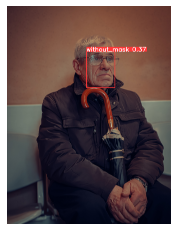

Image from: https://unsplash.com/photos/sO3WT9XJOhE


In [ ]:
%pylab inline
test_photo_path = Path("/content/drive/MyDrive/Machine Learning/testImage/test2.jpg")

results = model(test_photo_path)
plt.imshow(np.squeeze(results.render()))
plt.axis(False)
plt.show()
print('''Image from: https://www.freepik.com/free-photo/male-employee-wearing-face-mask-work-standing_11651930.htm#query=man%20mask&position=4&from_view=keyword''')

test_photo_path = Path("/content/drive/MyDrive/Machine Learning/testImage/002.jpg")

results = model(test_photo_path)
plt.imshow(np.squeeze(results.render()))
plt.axis(False)
plt.show()
print('''Image from: https://unsplash.com/photos/sO3WT9XJOhE''')

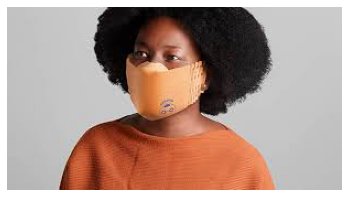

In [ ]:
test_photo_path = Path("/content/drive/MyDrive/Machine Learning/testImage/test3.jpeg")

results = model(test_photo_path)
plt.imshow(np.squeeze(results.render()))
plt.axis(False)
plt.show()

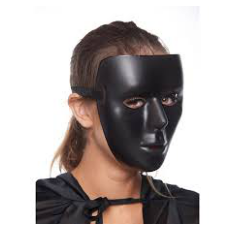

In [ ]:
test_photo_path = Path("/content/drive/MyDrive/Machine Learning/testImage/test4.jpeg")

results = model(test_photo_path)
plt.imshow(np.squeeze(results.render()))
plt.axis(False)
plt.show()

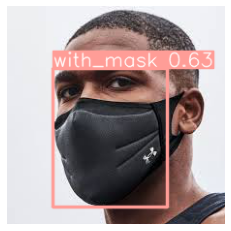

In [ ]:
test_photo_path = Path("/content/drive/MyDrive/Machine Learning/testImage/test5.jpeg")

results = model(test_photo_path)
plt.imshow(np.squeeze(results.render()))
plt.axis(False)
plt.show()

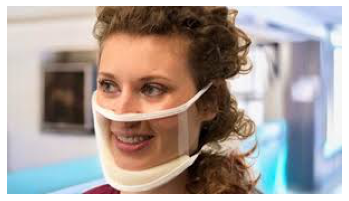

In [ ]:
test_photo_path = Path("/content/drive/MyDrive/Machine Learning/testImage/test6.jpeg")

results = model(test_photo_path)
plt.imshow(np.squeeze(results.render()))
plt.axis(False)
plt.show()

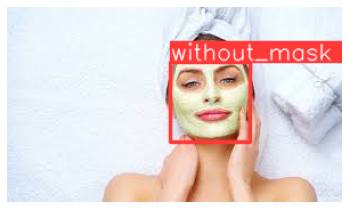

In [ ]:
test_photo_path = Path("/content/drive/MyDrive/Machine Learning/testImage/test7.jpeg")

results = model(test_photo_path)
plt.imshow(np.squeeze(results.render()))
plt.axis(False)
plt.show()

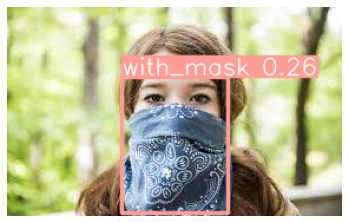

In [ ]:
test_photo_path = Path("/content/drive/MyDrive/Machine Learning/testImage/test8.jpeg")

results = model(test_photo_path)
plt.imshow(np.squeeze(results.render()))
plt.axis(False)
plt.show()

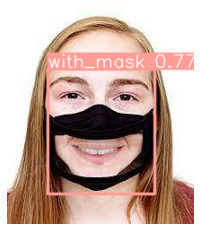

In [ ]:
test_photo_path = Path("/content/drive/MyDrive/Machine Learning/testImage/test9.jpeg")

results = model(test_photo_path)
plt.imshow(np.squeeze(results.render()))
plt.axis(False)
plt.show()

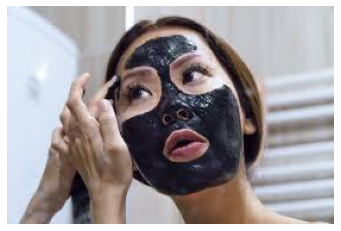

In [ ]:
test_photo_path = Path("/content/drive/MyDrive/Machine Learning/testImage/test10.jpeg")

results = model(test_photo_path)
plt.imshow(np.squeeze(results.render()))
plt.axis(False)
plt.show()

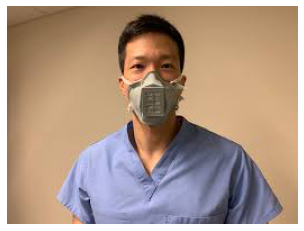

In [ ]:
test_photo_path = Path("/content/drive/MyDrive/Machine Learning/testImage/test11.jpeg")

results = model(test_photo_path)
plt.imshow(np.squeeze(results.render()))
plt.axis(False)
plt.show()

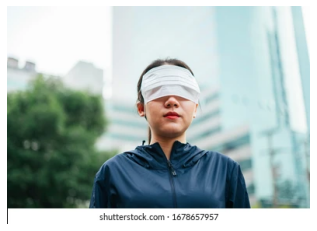

In [ ]:
test_photo_path = Path("/content/drive/MyDrive/Machine Learning/testImage/test12.jpeg")

results = model(test_photo_path)
plt.imshow(np.squeeze(results.render()))
plt.axis(False)
plt.show()